# Model

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import copy

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import stein
import run
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def plot_rundata(training, validation, true, title, ax=None):
    length = len(training)
    ax = plt.gca() if ax is None else ax
    colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax.plot(training, label=f"Training {title}")
    _ = ax.hlines(true, 0, length, colors=colorcycle, linestyles="dotted")
    ax.set_prop_cycle(color=colorcycle)
    ax.plot(validation, "--", label=f"Validation {title}")
    ax.legend()
    ax.set_title(title)

## Vanilla ARD

In [3]:
conf = copy.deepcopy(config.config)

conf["svgd"]["n_particles"] = 2000
conf["svgd"]["n_subsamples"] = 200

conf["kernel"]["architecture"] = "Vanilla"
conf["train_kernel"]["ksd_steps"] = 0
conf["train_kernel"]["svgd_steps"] = 1
conf["train_kernel"]["n_iter"] = config.config["train_kernel"]["n_iter"] // conf["train_kernel"]["svgd_steps"]
conf["train_kernel"]["optimizer_ksd_args"] = [0.0]

In [4]:
svgd_vanilla = SVGD(**config.get_svgd_args(conf))

In [5]:
kernel_params_vanilla, rundata_vanilla = svgd_vanilla.train_kernel(**config.get_train_args(conf))

  0%|          | 0/50 [00:00<?, ?it/s]/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


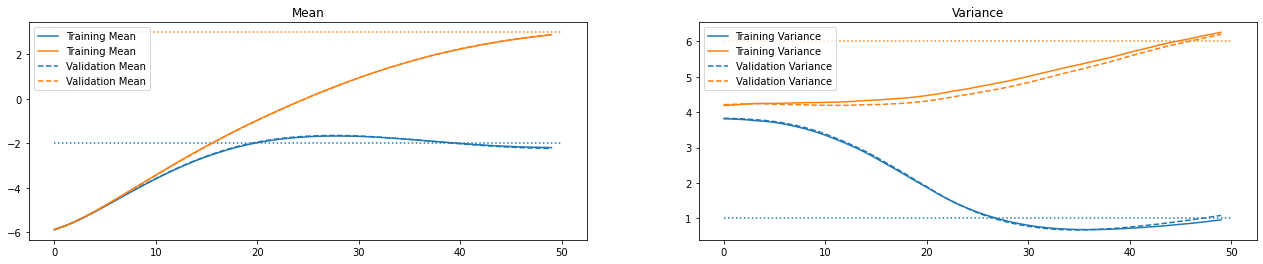

In [6]:
t_mean = onp.array(rundata_vanilla["training_mean"])
t_var = onp.array(rundata_vanilla["training_var"])
v_mean = onp.array(rundata_vanilla["validation_mean"])
v_var = onp.array(rundata_vanilla["validation_var"])
tru_mean = conf["svgd"]["target_args"][0]
tru_var = conf["svgd"]["target_args"][1]# if conf_mlp["svgd"]["target_args"][1].shape == (2,2) else diag(conf_mlp["svgd"]["target_args"][1])

fig, axs = plt.subplots(1, 2, figsize=[22, 4])
plot_rundata(t_mean, v_mean, tru_mean, "Mean", axs[0])
plot_rundata(t_var, v_var, tru_var, "Variance", axs[1])

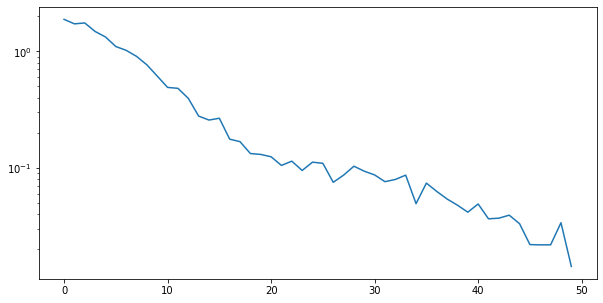

In [7]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(rundata_vanilla["ksd_after_svgd_update"])
ax.set_yscale("log")

In [8]:
# t_mean = onp.array(rundata_vanilla["training_mean"])
# t_var = onp.array(rundata_vanilla["training_var"])
# v_mean = onp.array(rundata_vanilla["validation_mean"])
# v_var = onp.array(rundata_vanilla["validation_var"])
# tru_mean = conf["svgd"]["target_args"][0]
# tru_var = conf["svgd"]["target_args"][1]# if conf_mlp["svgd"]["target_args"][1].shape == (2,2) else diag(conf_mlp["svgd"]["target_args"][1])
# grid = np.arange(len(t_mean))

# # fig, ax = plt.subplots(1,2, figsize=[14, 4])

# def plot_mean_and_var(mean, var, tru_mean, tru_var, ax=None):
#     colorcycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
#     ax = ax if ax is not None else plt.gca()
#     for i in range(2):
#         plot.errorfill(grid, mean[:, i], np.sqrt(var[:, i]), color=next(colorcycle), ax=ax)
#         ax.errorbar(len(t_mean), tru_mean[i], np.sqrt(tru_var[i]), marker="o", capsize=5)

# fig, axs = plt.subplots(1, 2, figsize=[14, 4])
# for m, v, ax, title in zip((t_mean, v_mean), (t_var, v_var), axs, ("Training", "Validation")):
#     plot_mean_and_var(m, v, tru_mean, tru_var, ax)
#     ax.set_title(title)

# MLP Kernel

In [24]:
conf_mlp = copy.deepcopy(config.config)

conf_mlp["svgd"]["n_particles"] = 2000
conf_mlp["svgd"]["n_subsamples"] = 200
conf_mlp["svgd"]["lam"] = 1


conf_mlp["kernel"]["architecture"] = "MLP"
conf_mlp["kernel"]["layers"] = [16, 32, 32, 2]
conf_mlp["train_kernel"]["ksd_steps"] = 20
conf_mlp["train_kernel"]["svgd_steps"] = 1
conf_mlp["train_kernel"]["n_iter"] = 40 #config.config["train_kernel"]["n_iter"] // conf_mlp["train_kernel"]["svgd_steps"]
conf_mlp["train_kernel"]["optimizer_ksd_args"] = [0.03]

In [25]:
svgd_mlp = SVGD(**config.get_svgd_args(conf_mlp))

In [ ]:
kernel_params_mlp, rundata_mlp = svgd_mlp.train_kernel(**config.get_train_args(conf_mlp))

  0%|          | 0/40 [00:00<?, ?it/s]/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [ ]:
t_mean = onp.array(rundata_mlp["training_mean"])
t_var = onp.array(rundata_mlp["training_var"])
v_mean = onp.array(rundata_mlp["validation_mean"])
v_var = onp.array(rundata_mlp["validation_var"])
tru_mean = conf["svgd"]["target_args"][0]
tru_var = conf["svgd"]["target_args"][1]# if conf_mlp["svgd"]["target_args"][1].shape == (2,2) else diag(conf_mlp["svgd"]["target_args"][1])

fig, axs = plt.subplots(1, 2, figsize=[22, 4])
plot_rundata(t_mean, v_mean, tru_mean, "Mean", axs[0])
plot_rundata(t_var, v_var, tru_var, "Variance", axs[1])

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(rundata_mlp["ksd_before_kernel_update"], ".", label="Training KSD")
ax.plot(rundata_mlp["ksd_before_kernel_update_val"], ".", label="Validation KSD")
# ax.plot(rundata_mlp["ksd_after_svgd_update"], ".", label="KSD after SVGD step")
ax.set_yscale("log")
_ = ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(rundata_mlp["bandwidth"])
ax.set_yscale("log")

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(rundata_mlp["autoencoder_loss"] * svgd_mlp.lam, label="autoencoder loss")
ax.plot(rundata_mlp["regularized_loss"], label="Total loss = autoencoder - KSD")
ax.plot(rundata_mlp["ksd_before_kernel_update"], label="KSD")
ax.legend()
# ax.set_yscale("log")

In [ ]:
def plot_update_to_weight_ratio(update_to_weight_ratio, scale="log"):
    con = utils.dict_concatenate(rundata_mlp["update_to_weight_ratio"])
    def visit(d, prefix=""):
        for k, v in d.items():
            if type(v) is jax.interpreters.xla.DeviceArray or type(v) is onp.ndarray or type(v) is list:
                plt.plot(v, label=prefix+"//"+k)
            else:
                visit(v, k)
    visit(con)
    plt.yscale(scale)
    plt.legend()

In [ ]:
plot_update_to_weight_ratio(rundata_mlp["update_to_weight_ratio"])

In [ ]:
def encoder_fn(x):
    """can take kernel_params"""
    layer_sizes = conf_mlp["kernel"]["layers"] = [16, 32, 32, 2]
    encoder = hk.nets.MLP(output_sizes=layer_sizes,
                    w_init=hk.initializers.VarianceScaling(scale=2.0),
                    activation=jax.nn.relu,
                    activate_final=False,
                    name="encoder")
    return encoder(x)
encoder = hk.transform(encoder_fn)

In [ ]:
def enc(x): return encoder.apply(kernel_params_mlp, x)

In [ ]:
sample = svgd_mlp.target.sample(1000)
out = vmap(enc)(sample)

In [ ]:
plot.bivariate_hist(sample)

In [ ]:
plot.bivariate_hist(out)

In [ ]:
# n_iter = conf_mlp["train_kernel"]["n_iter"]
# # ksd_kernel = np.split(rundata_mlp["ksd_after_kernel_update"], n_iter)
# # ksd_svgd = np.split(rundata_mlp["ksd_after_svgd_update"], n_iter)
# ksd_kernel = rundata_mlp["ksd_after_kernel_update"]

#     ax.plot(ksdss)


# for i, ksds in enumerate(ksd_kernel):
#     idx = range(40*i, 40*i+20)
# #     print("k range:", idx)
#     ax.plot(idx, ksds, ".b")

# for i, ksds in enumerate(ksd_svgd):
#     start = 40*(i+1) - 20
#     stop = 40*(i+1)
#     step = 5
#     idx = range(start, stop, step)
# #     print("s range:", idx)
#     ax.plot(idx, ksds, ".r")
